In [51]:
%pylab inline
import gwpy
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import astropy.units as u
import astropy.cosmology
import swyft
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers
import torch
from astropy.cosmology import Planck18, z_at_value, Planck13, Planck15
from scipy.integrate import quad
from scipy import interpolate
from sklearn.preprocessing import StandardScaler
from astropy.constants import pc, c
import scipy
import jax
from jaxinterp2d import interp2d
import seaborn as sns
from jax import jit
import jax.numpy as jnp
from jax import device_get
import numpyro
import arviz as az
import numpyro.distributions as dist
from gwpy.timeseries import TimeSeries
from numpyro.infer import MCMC, NUTS
np.random.seed(3407)
jax.config.update("jax_enable_x64", True)
sns.set(style='ticks', context='notebook', font='serif', 
        font_scale=1.5, palette='deep')
rc_params = {'backend': 'pdf',
             'axes.labelsize': 24,
             'axes.titlesize': 32,
             'font.size': 18,
             'legend.fontsize': 18,
             'xtick.labelsize': 24,
             'ytick.labelsize': 24,
             'font.family': 'serif',
             'font.sans-serif': ['Bitstream Vera Sans'],
             'font.serif': ['Times New Roman'],
             'text.usetex':True,
            }
plt.rcParams["text.usetex"] = "true"

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['axes', 'fix']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [37]:
# Define simulator parameters
f_low = 10
f_high = 1000
N_bins = 4096
freq = np.linspace(f_low, f_high, N_bins)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=len(freq), bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(f_low, f_high, N_bins)
        self.sample_z = swyft.RectBoundSampler([stats.uniform(-12,5), #omega
                                                stats.uniform(0,5)], #alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        #denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        denomenator = (3*H0**2)**2 * 8
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = 10**z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m)
        sigma = graph.node('sigma',self.sigma)

In [27]:
# Define swyft network

import torch.nn as nn
import torch.nn.functional as F

class AE(swyft.SwyftModule,swyft.AdamWReduceLROnPlateau):
    def __init__(self, lr = 1e-5, weight_decay = 0.05):
        super().__init__()
        
        marginals = ((0,1), )
        self.learning_rate = lr
        self.weight_decay = weight_decay
        #swyft.OptimizerInit(torch.optim.Adam, dict(lr = lr),
              #torch.optim.lr_scheduler.ReduceLROnPlateau, dict(factor = 0.3, patience=5))
        # AE-Summarizer
        self.summarizer =  nn.Sequential(
            nn.Linear(4096, 2048),
            nn.GELU(),
            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 16),
            nn.GELU(),
            nn.Linear(16, 2),
            nn.GELU(),
        )

        
        self.logratios_1D = swyft.LogRatioEstimator_1dim(
            num_features=2,  # Number of features in compressed x (simulated observation)
            num_params=2,    # Two parameters to infer: alpha and omega
            varnames='z', 
            dropout = 0.0# Names of the parameters
            # Number of neural network blocks
        )
            
        self.logratios_2D = swyft.LogRatioEstimator_Ndim(num_features = 2, 
                                                       marginals = marginals, varnames = 'z', num_blocks = 4,  dropout = 0.0)
        
            
    def forward(self, A, B):
        s = self.summarizer(A['x'])

        return self.logratios_1D(s, B['z']),  self.logratios_2D(s, B['z'])


In [44]:
class VAE(swyft.SwyftModule):
    def __init__(self, lr=1e-5):
        super(VAE, self).__init__()
        
        self.learning_rate = lr
        # Encoder layers (same as before, but with mu and logvar layers)
        self.encoder_fc1 = nn.Linear(4096, 2048)
        self.encoder_ln1 = nn.LayerNorm(2048)

        self.encoder_fc2 = nn.Linear( 2048, 1024)
        self.encoder_ln2 = nn.LayerNorm(1024)

        self.encoder_fc3 = nn.Linear(1024, 512)
        self.encoder_ln3 = nn.LayerNorm(512)

        self.encoder_fc4 = nn.Linear(512, 256)
        self.encoder_ln4 = nn.LayerNorm(256)

        self.encoder_fc5 = nn.Linear( 256, 128)
        self.encoder_ln5 = nn.LayerNorm(128)

        self.encoder_fc6 = nn.Linear(128, 64)
        self.encoder_ln6 = nn.LayerNorm(64)

        self.encoder_fc7 = nn.Linear(64, 32)
        self.encoder_ln7 = nn.LayerNorm(32)
        
        # Latent space mean and log variance
        self.fc_mu = nn.Linear(32,16) # bigger latent space improved learning 
        self.fc_logvar = nn.Linear(32, 16)
        
        self.dropout = nn.Dropout(0.1)

        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 16, num_params = 2, varnames = 'z') 
    
        self.logratios2 = swyft.LogRatioEstimator_Ndim(
            num_features=16,
            marginals=[(0, 1)],
            varnames='z',
            num_blocks=4
        )

    def encode(self, x):
        x = F.leaky_relu(self.encoder_ln1(self.encoder_fc1(x)))
        x = F.leaky_relu(self.encoder_ln2(self.encoder_fc2(x)))
        x = F.leaky_relu(self.encoder_ln3(self.encoder_fc3(x)))
        x = F.leaky_relu(self.encoder_ln4(self.encoder_fc4(x)))
        x = F.leaky_relu(self.encoder_ln5(self.encoder_fc5(x)))
        x = F.leaky_relu(self.encoder_ln6(self.encoder_fc6(x)))
        x = F.leaky_relu(self.encoder_ln7(self.encoder_fc7(x)))
        
    
        # Get the mean and log variance for the latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick: z = mu + sigma * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # random noise
        z = mu + eps * std # latent variable
        return z
    
    def forward(self, A,B):
        mu, logvar = self.encode(A['x'])
        z = self.reparameterize(mu, logvar)
        z = self.dropout(z)
        logratios1= self.logratios1(z, B['z'])
        logratios2 = self.logratios2(z, B['z'])
        return logratios1, z, logratios2

In [63]:
# Sample from Simulator

n_samples = 5000
fref = 25
CE_PSD = np.genfromtxt("../Abby/data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("../Abby/data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
sigma = sim.sigma()

In [64]:
sims = sim.sample(N = n_samples)
# This step is very important!
# Maybe we can find a better way to do it!
#sims['x'] = np.log10(np.abs(sims['x'])/sigma)

100%|██████████| 5000/5000 [00:09<00:00, 549.22it/s]


In [65]:
idx = sims['x']<=0
sims['x'] = np.where(sims['x'] < 0, sigma, sims['x'])
sims['x'] = np.log10(sims['x']/sigma)

scaler_x = StandardScaler()
sims['x'] = scaler_x.fit_transform(sims['x'])

In [66]:
ckpt = torch.load(
    "/scratch/haowen.zhong/SBI/logs/AE_logs/version_21/checkpoints/epoch=146-step=5880.ckpt",
    map_location=torch.device('cpu')
)
network = VAE()
network.load_state_dict(ckpt['state_dict'])
network.eval()
lr_monitor = LearningRateMonitor(logging_interval='step')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=3, verbose=False, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='/scratch/haowen.zhong/SBI/logs/', filename='CC_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min')
logger = pl_loggers.TensorBoardLogger(save_dir='/scratch/haowen.zhong/SBI/logs/', name='AE_logs', version=None)

trainer = swyft.SwyftTrainer(accelerator = 'cpu', max_epochs = 50, auto_lr_find=True, logger=logger, callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback], precision=64)

/tmp/ipykernel_3615770/577657858.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
GPU available: False, used: False
TPU available: False, using: 0 TPU 

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 98/98 [00:07<00:00, 13.86it/s]


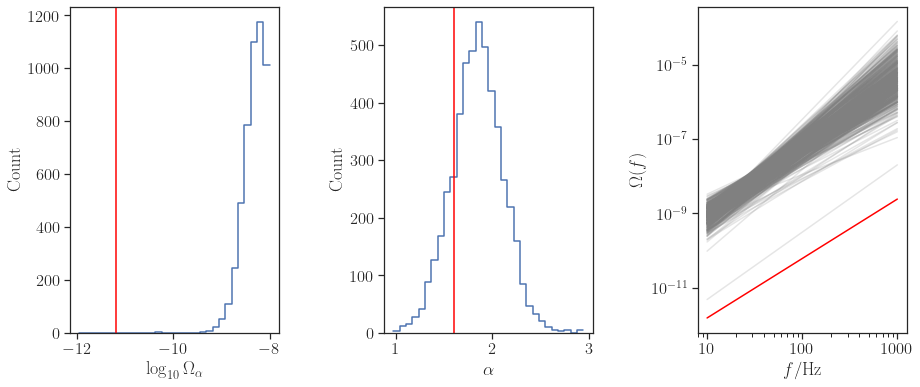

In [67]:
# Define priors
omega_prior = stats.uniform(-12, 4)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(0, 5)                # Uniform distribution for alpha

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(100_000)
z_alpha = alpha_prior.rvs(100_000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, test_data, prior_samples)


ln_r = np.asarray(predictions[0].logratios)
r_1 = np.exp(ln_r[:, 0])
r_2 = np.exp(ln_r[:, 1])
post_Omega = np.random.choice(z_samps[:, 0], size=5000, p = r_1/np.sum(r_1))
post_alpha = np.random.choice(z_samps[:, 1], size=5000, p = r_2/np.sum(r_2))
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(sims[0]['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(sims[0]['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    #plt.loglog(sim.freq, post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**sims[0]['z'][0]*(sim.freq/sim.fref)**sims[0]['z'][1], color="red")
#plt.loglog(sim.freq, test_data['z'][0, 0]*(sim.freq/sim.fref)**test_data['z'][0, 1], color="red")

In [69]:
coverage_samples = trainer.test_coverage(network, sims[-500:], prior_samples[-2000:])

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0:   0%|          | 51/49000 [00:10<2:47:12,  4.88it/s]
Predicting: 16it [00:00, 58.34it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 1000/1000 [01:00<00:00, 16.55it/s]


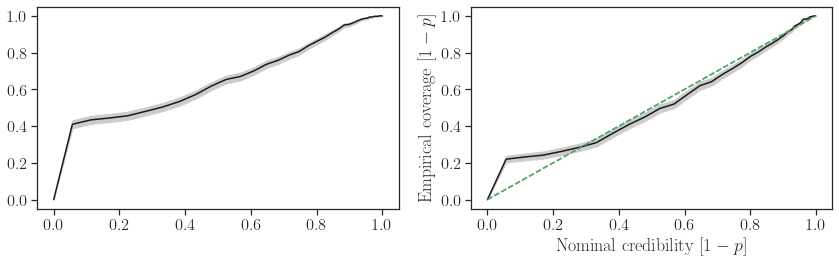

In [57]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    swyft.plot_pp(coverage_samples, "z[%i]"%i, ax = axes[i])
plt.tight_layout()

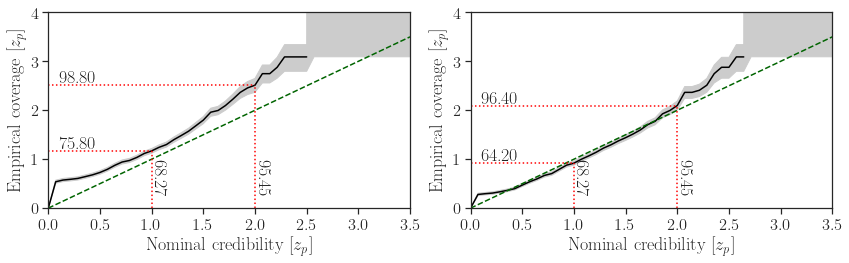

In [58]:
# zz-plot, emphasize high-credibility regionn and visualize uncertainties
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    swyft.plot_zz(coverage_samples, "z[%i]"%i, ax = axes[i])
plt.tight_layout()

In [71]:
swyft.SwyftTrainer?

Init signature:
swyft.SwyftTrainer(
    logger: Union[pytorch_lightning.loggers.logger.Logger, Iterable[pytorch_lightning.loggers.logger.Logger], bool] = True,
    enable_checkpointing: bool = True,
    callbacks: Union[List[pytorch_lightning.callbacks.callback.Callback], pytorch_lightning.callbacks.callback.Callback, NoneType] = None,
    default_root_dir: Union[str, pathlib.Path, NoneType] = None,
    gradient_clip_val: Union[int, float, NoneType] = None,
    gradient_clip_algorithm: Optional[str] = None,
    num_nodes: int = 1,
    num_processes: Optional[int] = None,
    devices: Union[List[int], str, int, NoneType] = None,
    gpus: Union[List[int], str, int, NoneType] = None,
    auto_select_gpus: Optional[bool] = None,
    tpu_cores: Union[List[int], str, int, NoneType] = None,
    ipus: Optional[int] = None,
    enable_progress_bar: bool = True,
    overfit_batches: Union[int, float] = 0.0,
    track_grad_norm: Union[int, float, str] = -1,
    check_val_every_n_epoch: Optional[

In [72]:
trainer.test_coverage?

Signature: trainer.test_coverage(model, A, B, batch_size=1024, logratio_noise=True)
Docstring:
Estimate empirical mass.

Args:
    model: network
    A: truth samples
    B: prior samples
    batch_size: batch sized used during network evaluation
    logratio_noise: Add a small amount of noise to log-ratio estimates, which stabilizes mass estimates for classification tasks.

Returns:
    Dict of CoverageSamples objects.
File:      ~/.conda/envs/Hierfit/lib/python3.11/site-packages/swyft/lightning/core.py
Type:      method

<Axes: ylabel='Count'>

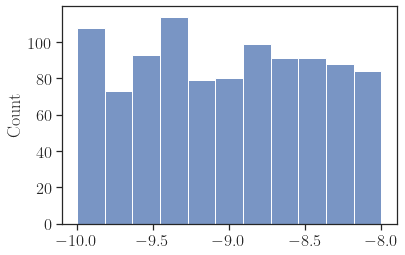

In [75]:
sns.histplot(np.log10(stats.loguniform(1e-10, 1e-8).rvs(1000)))